# Lab Activity 5.4. Predicting the Sound Level of Aerofoils (in decibel)

In this activity, you will perform a regression task on the [Airfoil Dataset](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise) provided by NASA. The fields names are slightly changed to better reflect the functionality. The dataset has about 1500 data points, each with 5 attributes and one target value. We are interested to guess (predict) the sound level generated by the different aerofoils tests with various wind tunnel speeds and angles of attack, that were conducted by NASA.

**Learning Outcomes**
1. Apply Least Squares on univariate linear regression model
2. Apply Least Squares on multivariate linear regression model
3. Understand the meaning of SSE, MSE and RMSE in a practical context
4. Employ different basis functions with linear models to obtain a generalised linear model
5. Appreciate the difficulty of choosing a suitable basis function
6. Employ simple visualisation to get insights of the dataset characteristics


## Load the data

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
airfoil = pd.read_csv('airfoil_self_noise.csv') #  we assume that you have this file in the same directory of this notebook!

In [3]:
airfoil.head()

,Frequency(Hertzs),Angle_of_attack(degrees),Chord_length(meters),Free_stream_velocity(m^2/s),Suction_displacement_thickness(meters),Scaled_sound_pressure_level(decibels)
0,20000,0.0,0.2286,71.3,0.002143,114.474
1,20000,4.0,0.2286,71.3,0.004006,109.638
2,20000,0.0,0.0254,71.3,0.000401,123.217
3,20000,0.0,0.0254,55.5,0.000412,121.933
4,20000,4.8,0.0254,71.3,0.000849,119.708


In [4]:
print(airfoil.columns)

Index(['Frequency(Hertzs)', 'Angle_of_attack(degrees)', 'Chord_length(meters)',
       ' Free_stream_velocity(m^2/s)',
       ' Suction_displacement_thickness(meters)',
       'Scaled_sound_pressure_level(decibels)'],
      dtype='object')


We want to predict the Scaled_sound_pressure_level(decibels)

<AxesSubplot: >

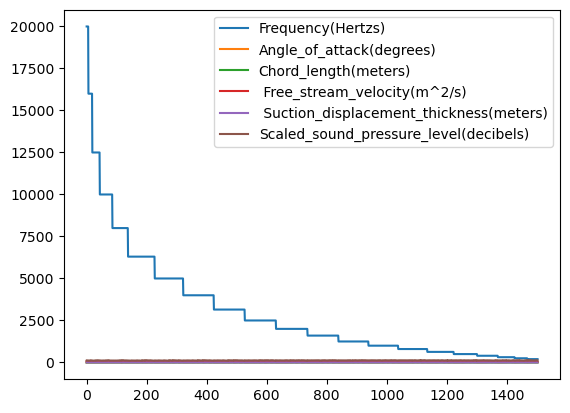

In [5]:
airfoil.plot()

From the above it is clear that one attribute (Frequency) is dominating other attributes and we need to perfrom rescaling.

## First Data Preperation and Data Sanity

Check if there is a missing data

In [6]:
np.where(pd.isnull(airfoil))

(array([], dtype=int64), array([], dtype=int64))

The above shows that there are no empty entries. 

## 1D Linear Model

In [7]:
D = airfoil.to_numpy()
D = np.asmatrix(D) # to make matrix multiplication easier

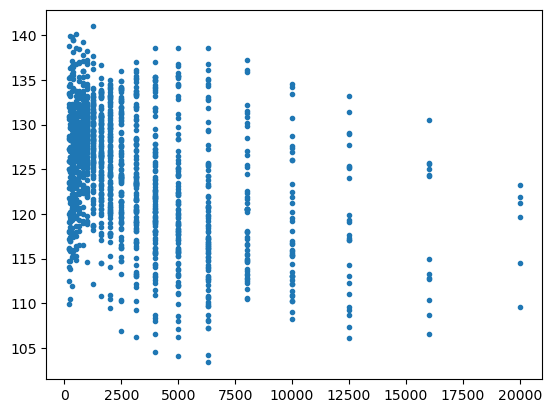

In [8]:
plt.plot(D[:,0],D[:,5],'.')

As we can see, each frequency band corresponds to several different sound pressure targets values.
Therefore, one attribute will not be capable of predicting the target value.

### Shape the data 

In [9]:
x = D[:,0]
t = D[:,5] 
N = x.size
x = ((x-x.min(0))/(x.max(0)-x.min(0))) 
X = np.c_[np.ones(N),x]    # add dummy attribute
w = np.ones((2,1))         # initialise the weights
y = X*w                    # predict
print(X[:5])

[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]


### Apply the Ordinary Least Squares solution for the identity basis (so $\Phi=X$)

In [10]:
# apply the closed form solution of least squares
F = (X.T*X).I
z = X.T*t
w = F*z
print(w)

[[127.13274179]
 [-16.92858445]]


This shows that the bias w[0] plays an important role in this univariate model.

In [11]:
# calculate the sum of squared errors
Res = X*w -t
SE1 = Res.T*Res
print(SE1)

[[60570.20622271]]


### Discussion of the meaning of SSE
The above SSE value is deceivingly large. Can you think why?
Think about it, this is the sum of squared errors. So, the larger the dataset the larger this value is going to get, even if the individual errors themselves are small.

Hence, we will take the mean of the squared error.


In [12]:
N = X.shape[0]
MSE1 = (1/N)*SE1
print(MSE1)

[[40.2995384]]


The MSE value is a more reasonable metric that reflects closer on average how big or small we expect the error (deviation) of our model prediction from the real values for *individual* records.
However, we still can do better if we cancel the effect of squaring those individual errors.


Think how should we do that?


...


We can simply take the square root of the MSE. This way we get an estimation of each record to be +- the RMSE value. And this will be in harmony with whatever unit is intrinsically used in the target (instead of the squares of the unit as is the case with MSE).

In [13]:
RMSE1 = np.sqrt(MSE1)
print(RMSE1)

[[6.34819174]]


RMSE is a better reflection of the capabilities of our prediction model. As it stands, we expect our model prediction to deviate by $\pm 6.3$ *on average* from the actual value. This does not guarantee that some errors might be larger than this average. In fact, we can do further analysis on which of those records will exceed this value in order to see if this is caused by spurious data points (outliers).

#### Double checking our results 
We can check our answer by utilising the lstsq function from numpy

In [14]:
np.linalg.lstsq(X, t,rcond=None)[0] # [0] returns the weights [1] returns the SE

matrix([[127.13274179],
        [-16.92858445]])

We can see that our solution is correct albeit the RMSE is higher than what we want it to be (indicating that the model is not able to capture the relationship between frequency and sound level).


The question remains is that is it possible to improve the performance of our model further?

We can do so by increasing the complexity of our model since we have done reasonable pre-processing steps already. We have few options:
1. Add more features from the dataset to help the model
2. Increase the complexity of our model by using different basis
3. Both of the above
4. Use a nonlinear model (but we will confine ourselves to the linear model case in this exercise)


### 1- Add more features

Ok this time we will create functions so that we can use them later

In [15]:
def shapeDF(DF,target,normalise=True):
    DFtarg = DF[[target]]                           # separate the target column in a dataframe
    #DF = DF.select_dtypes(include=['float64'])     # get only fileds that are numerical 
    DF = DF.drop([target], axis=1)                  # remove the target fields from the training data
    
    x = np.asmatrix(DF.to_numpy())                  # convert to a numpy array and then to a matrix 
    t = np.asmatrix(DFtarg.to_numpy())
    if(normalise): 
        x = ((x-x.min(0))/(x.max(0)-x.min(0)))      # normalise by rescaling the data
        
    return x,t

In [16]:
def LSQ(x,t):
    # apply the closed form solution of least squares
    N = x.shape[0]
    #M = x.shape[1]

    X = np.c_[np.ones(N),x]                         # add the dummy field
    #X,X[:,1:] = np.ones((N,M+1)),x                 # same as above, this one is faster but less readable    

    F = (X.T*X).I
    z = X.T*t
    w = F*z
    return w, X

In [17]:
def SSE(X,t,w):
    # calculates the sum of squared errors
    Residuals = X*w - t
    SSE = Residuals.T*Residuals
    return SSE

def MSE(X,t,w):
    # calculates the mean of squared errors
    N = X.shape[0]
    MSE = (1.0/N)*SSE(X,t,w)
    return MSE

def RMSE(X,t,w):
    # calculates the root mean of squared errors
    RMSE = np.sqrt(MSE(X,t,w))
    return RMSE
    

Now we have created general functions that we can call to prepare the data, fit a least square model and calculate the sum of squared errors for our soultion

In [18]:
x,t = shapeDF(airfoil, target='Scaled_sound_pressure_level(decibels)')
print(t.shape)
w,X = LSQ(x,t)
SE2 = SSE(X,t,w)
MSE2  = MSE(X,t,w)
RMSE2 = RMSE(X,t,w)


print(w)
print('Sum of Squared Errors = ', SE2)
print('Mean of Squared Errors = ', MSE2)
print('Root Mean of Squared Errors = ', RMSE2) 
# the RMSE is a more accurate measure of per-sample deviation from the 
# true value of the target (in this case, sound decibel levels)


(1503, 1)
[[134.77724168]
 [-25.38770076]
 [ -9.36643987]
 [ -9.97122754]
 [  3.95422018]
 [ -8.54499413]]
Sum of Squared Errors =  [[34618.21913267]]
Mean of Squared Errors =  [[23.03274726]]
Root Mean of Squared Errors =  [[4.79924445]]


Note that it is not advised to call all of these functions together as we did earlier for comparison, since this would lead to duplications of the calculation of the residuals 3 times. This is not a problem here, but we can come up with a better way of doing this by combining all the three functions into one that yields the SSE, MSE and RMSE in one go.

In [19]:
RMSE2<RMSE1

matrix([[ True]])

By comparing SE1 (univariate input) and SE2 (multivariate input) we can see that adding more features improved the performance of our model.
For sanity, let us again compare our results with those of numpy lstsq function, note that the results should be almost identical, the 'almost' is because lstsq uses a more tailored inversion for the design matrix called SVD.

In [20]:
SE2_ = np.linalg.lstsq(X, t,rcond=None)[1] # [0] returns the weights [1] returns the SSE
print(SE2_)
print(SE2_ == SE2)
print(SE2_ - SE2)


[[34618.21913267]]
[[False]]
[[7.27595761e-11]]


So we see again that our solution is almost identical to the one provided by numpy, jolly good... let us move to the next option to improve our model.

### 2- Use a Different Basis

#### Polynomial

Note: the below is just one option for a polynomial, you can raise different features to different powers, which would be more effective but you would need more domain knowledge to do that. This also shows the issue of fixed basis models which are difficult to tune their basis. While, as you will see later in non-linear models making the basis adaptable, makes the model more powerful to capture the essence of the data. Of course, this is done on the cost of more complexity and issues arises due to learning those basis, [‘no free lunch theorem’](https://en.wikipedia.org/wiki/No_free_lunch_theorem).

In [21]:
def polyBasis(x,k):
    #Phi = np.power(x,k)
    Phi = x
    for i in range(k):
        Phi = np.multiply(Phi,x)
    
    return Phi

In [22]:
def LSQ_Basis(x,t,funBasis,k=1):    
    #k   = 1 # try different k's 1 is equivalent to keeping the input space as is
    #Phi = polyBasis(x,k)
    Phi   = funBasis(x,k)
    w,Phi = LSQ(Phi,t)
    RMSE_ = RMSE(Phi,t,w)    
    return RMSE_,w

In [23]:
RMSE3,w = LSQ_Basis(x,t,polyBasis,2)
print('weights = \n', w,'\nRoot Mean Squared Errors = ', RMSE3, 'and  SE3 < SE2 is', RMSE3 <= RMSE2)


weights = 
 [[127.33211014]
 [-21.47781732]
 [ -6.07218408]
 [ -6.54624148]
 [  2.32469499]
 [-14.77339903]] 
Root Mean Squared Errors =  [[5.92585655]] and  SE3 < SE2 is [[False]]


So we could not improve the performance via the simple polynomial basis that we used. Let us see if this can be done via Radial Basis Functions.

#### Radial Basis Functions

The following function attempt to get a set of rbf basis with different centres but same variances with all co-variances assumed to be 0.

In [24]:
def RbfBasis_(X,k, vr=1): # k represents how many components(basis) will come out        
    N  = X.shape[0]
    M  = X.shape[1]

    np.random.seed()
    eps = abs(np.random.rand(k,M))#/10              # generate a set of random centres
    # Please note that better than picking random centres, we could employ clustering see next task in this notebook.
    
    Mu  = np.add(X.mean(0) ,eps)

    #vr = 1.2#1/(1000*k)                           # manually setting the var as a normalisation factor
    #vr    = X.var()
    #Sigma_1 = np.multiply(np.eye(M),1/X.var(0))    # to get the inverse of the covariance matrix cheaply each feature in X has its own variance but all covariances are 0

    Phi = np.asmatrix(np.ones((N,k)))
    for b in range(k):
        Diff   = (X   - Mu[b,:])
        
        # you could use the following 2 lines instead of the line * if you want to have a covariance matrix with different variance and co-variance on each component
        #DiffxS = Diff.multiply(Diff) * Sigma_1 
        #Phi[:,b] = np.exp(-0.5*np.sum(np.multiply(Diff,DiffxS),1))
        
        Phi[:,b] = np.exp(-(1.0/(2*vr))*np.multiply(Diff, Diff).sum(1))  
        
    return Phi

In [25]:
# this will produce a set of features that has the number of the attributes in the dataset.

RMSE4,w = LSQ_Basis(x,t,RbfBasis_,5)
print('weights = \n', w,'\n Root Mean Squared Errors = ', RMSE3, 'and  RMSE4 < RMSE3 is', RMSE4 <= RMSE3)


weights = 
 [[ 132.90471381]
 [-229.51275789]
 [  53.25064014]
 [ 114.20095637]
 [ -23.04998756]
 [  19.20269255]] 
 Root Mean Squared Errors =  [[5.92585655]] and  RMSE4 < RMSE3 is [[ True]]


**Note.** The following code cell may take a longer time to run, be patient!

In [26]:
i = 1
while i < 500:
    k   = np.random.randint(1,100) # number of Gaussian basis    
    
    RMSE4,w = LSQ_Basis(x,t,RbfBasis_,k)    
    
    if(i==1 or RMSE4 < RMSE4_best):  RMSE4_best, w_best = RMSE4,w    
    
    i += 1

print('best weights have ', w_best.shape[0],' components \nRoot Mean of Squared Errors = ',
      RMSE4_best, 'and  RMSE4 < RMSE3 is', RMSE4_best <= RMSE4)

best weights have  100  components 
Root Mean of Squared Errors =  [[2.89433786]] and  RMSE4 < RMSE3 is [[ True]]


## Your Turn

1. Apply the above exercise on the following [students dataset](https://archive.ics.uci.edu/ml/datasets/Student+Performance)

2. Try to employ K-means clustering to discover a sensible set of centres instead of picking random centres.

3. Split the data into training and testing and apply the above training procedures on the training data and measure the performance (RMSE, R2) on the testing data.

4. Consider applying cross validation in the parameter optimisation procedure

In [27]:
# Re-importing necessary libraries for state reset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the provided datasets
math_file_path = 'student-mat.csv'
por_file_path = 'student-por.csv'

# Read the datasets
math_data = pd.read_csv(math_file_path, sep=";")
por_data = pd.read_csv(por_file_path, sep=";")

# Use the Math dataset for simplicity
data = math_data.copy()

# Preprocess the dataset
# Select numeric features and remove missing values (if any)
numeric_data = data.select_dtypes(include=[np.number]).dropna()

# Define features (X) and target (y)
X = numeric_data.drop(columns=["G3"])  # "G3" is the final grade (target)
y = numeric_data["G3"]

# Normalize features for stability
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Use K-means clustering to determine centers for Gaussian basis functions
kmeans = KMeans(n_clusters=10, random_state=42)  # Using 10 clusters
kmeans.fit(X_train)
centers = kmeans.cluster_centers_

# Define a Gaussian basis transformation function
def gaussian_basis_transform(X, centers, gamma=0.5):
    """
    Apply Gaussian basis transformation to data.
    :param X: Input features
    :param centers: Cluster centers
    :param gamma: Scaling factor
    :return: Transformed features
    """
    transformed = np.exp(-gamma * np.linalg.norm(X[:, np.newaxis] - centers, axis=2) ** 2)
    return transformed

# Transform training and testing data using Gaussian basis functions
X_train_gaussian = gaussian_basis_transform(X_train, centers)
X_test_gaussian = gaussian_basis_transform(X_test, centers)

# Train a Ridge Regression model
ridge = Ridge(alpha=1.0)  # Regularization strength
ridge.fit(X_train_gaussian, y_train)

# Predict on test data
y_pred = ridge.predict(X_test_gaussian)

# Evaluate model performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Ridge Regression with Gaussian Basis:\nRMSE: {rmse:.4f}\nR2: {r2:.4f}")

# Perform cross-validation to optimize hyperparameters
param_grid = {"alpha": [0.1, 1.0, 10.0, 100.0]}
grid_search = GridSearchCV(Ridge(), param_grid, scoring="neg_mean_squared_error", cv=5)
grid_search.fit(X_train_gaussian, y_train)

# Get the best alpha and corresponding performance
best_alpha = grid_search.best_params_["alpha"]
best_rmse_cv = np.sqrt(-grid_search.best_score_)

print(f"\nBest Hyperparameter (alpha): {best_alpha}")
print(f"Cross-validated RMSE: {best_rmse_cv:.4f}")

# Re-train the model with the best alpha
ridge_optimized = Ridge(alpha=best_alpha)
ridge_optimized.fit(X_train_gaussian, y_train)
y_pred_optimized = ridge_optimized.predict(X_test_gaussian)

# Final evaluation after optimization
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_optimized))
final_r2 = r2_score(y_test, y_pred_optimized)

print(f"\nOptimized Ridge Regression:\nRMSE: {final_rmse:.4f}\nR2: {final_r2:.4f}")

Ridge Regression with Gaussian Basis:
RMSE: 4.4246
R2: 0.0453

Best Hyperparameter (alpha): 0.1
Cross-validated RMSE: 4.4089

Optimized Ridge Regression:
RMSE: 4.2017
R2: 0.1390


### Apply Same Regression Analysis on Student Dataset or any other regression dataset of your choice.

A sample solution is given below:

In [28]:
# Load the datasets again for regression analysis
math_file_path = 'student-mat.csv'
por_file_path = 'student-por.csv'

# Read the datasets
math_data = pd.read_csv(math_file_path, sep=";")
por_data = pd.read_csv(por_file_path, sep=";")

# Define a function to perform regression analysis on a dataset
def perform_regression_analysis(data, dataset_name):
    # Preprocess the dataset
    numeric_data = data.select_dtypes(include=[np.number]).dropna()
    X = numeric_data.drop(columns=["G3"])  # "G3" is the final grade (target)
    y = numeric_data["G3"]
    
    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Use K-means clustering to determine centers for Gaussian basis functions
    kmeans = KMeans(n_clusters=10, random_state=42)
    kmeans.fit(X_train)
    centers = kmeans.cluster_centers_
    
    # Transform data using Gaussian basis functions
    X_train_gaussian = gaussian_basis_transform(X_train, centers)
    X_test_gaussian = gaussian_basis_transform(X_test, centers)
    
    # Train Ridge Regression model
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train_gaussian, y_train)
    y_pred = ridge.predict(X_test_gaussian)
    
    # Evaluate initial model performance
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"\n{dataset_name} - Initial Ridge Regression:\nRMSE: {rmse:.4f}\nR2: {r2:.4f}")
    
    # Perform cross-validation for hyperparameter optimization
    param_grid = {"alpha": [0.1, 1.0, 10.0, 100.0]}
    grid_search = GridSearchCV(Ridge(), param_grid, scoring="neg_mean_squared_error", cv=5)
    grid_search.fit(X_train_gaussian, y_train)
    
    # Get the best alpha and corresponding performance
    best_alpha = grid_search.best_params_["alpha"]
    best_rmse_cv = np.sqrt(-grid_search.best_score_)
    print(f"\n{dataset_name} - Best Hyperparameter (alpha): {best_alpha}")
    print(f"{dataset_name} - Cross-validated RMSE: {best_rmse_cv:.4f}")
    
    # Re-train with optimized alpha
    ridge_optimized = Ridge(alpha=best_alpha)
    ridge_optimized.fit(X_train_gaussian, y_train)
    y_pred_optimized = ridge_optimized.predict(X_test_gaussian)
    
    # Final evaluation
    final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_optimized))
    final_r2 = r2_score(y_test, y_pred_optimized)
    print(f"\n{dataset_name} - Optimized Ridge Regression:\nRMSE: {final_rmse:.4f}\nR2: {final_r2:.4f}")

# Perform regression analysis on Math dataset
perform_regression_analysis(math_data, "Math Dataset")

# Perform regression analysis on Portuguese dataset
perform_regression_analysis(por_data, "Portuguese Dataset")


Math Dataset - Initial Ridge Regression:
RMSE: 4.4246
R2: 0.0453

Math Dataset - Best Hyperparameter (alpha): 0.1
Math Dataset - Cross-validated RMSE: 4.4089

Math Dataset - Optimized Ridge Regression:
RMSE: 4.2017
R2: 0.1390

Portuguese Dataset - Initial Ridge Regression:
RMSE: 3.1387
R2: -0.0102

Portuguese Dataset - Best Hyperparameter (alpha): 0.1
Portuguese Dataset - Cross-validated RMSE: 3.0108

Portuguese Dataset - Optimized Ridge Regression:
RMSE: 3.1212
R2: 0.0010


### Insights:
- For the **Math Dataset**, there is a notable improvement in $R^2$ and RMSE after hyperparameter optimization, suggesting the model better fits the data with an optimized regularization parameter.
- For the **Portuguese Dataset**, the model struggles to explain the variance in the target $R^2$ close to 0), even after optimization, indicating potential challenges such as insufficient feature representation or high noise in the data.


### Try to use Clustering to select RBF Centres

Please note that we could do better than picking random centres. Try to apply the ideas of clustering here.
What you could do, is to cluster the dataset first, take the centroids as the RBF centres and see if those centres make the results better. A sample solution is given below:

In [29]:
# Function to apply clustering-based RBF centers and perform regression
def regression_with_clustering(data, dataset_name, n_clusters=10):
    # Preprocess the dataset
    numeric_data = data.select_dtypes(include=[np.number]).dropna()
    X = numeric_data.drop(columns=["G3"])  # "G3" is the final grade (target)
    y = numeric_data["G3"]
    
    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Use K-means clustering to determine RBF centers
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_train)
    centers = kmeans.cluster_centers_
    
    # Transform data using Gaussian basis functions with cluster-based centers
    X_train_gaussian = gaussian_basis_transform(X_train, centers)
    X_test_gaussian = gaussian_basis_transform(X_test, centers)
    
    # Train Ridge Regression model
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train_gaussian, y_train)
    y_pred = ridge.predict(X_test_gaussian)
    
    # Evaluate initial model performance
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"\n{dataset_name} - Clustering-based Ridge Regression:\nRMSE: {rmse:.4f}\nR2: {r2:.4f}")
    
    # Perform cross-validation for hyperparameter optimization
    param_grid = {"alpha": [0.1, 1.0, 10.0, 100.0]}
    grid_search = GridSearchCV(Ridge(), param_grid, scoring="neg_mean_squared_error", cv=5)
    grid_search.fit(X_train_gaussian, y_train)
    
    # Get the best alpha and corresponding performance
    best_alpha = grid_search.best_params_["alpha"]
    best_rmse_cv = np.sqrt(-grid_search.best_score_)
    print(f"\n{dataset_name} - Best Hyperparameter (alpha): {best_alpha}")
    print(f"{dataset_name} - Cross-validated RMSE: {best_rmse_cv:.4f}")
    
    # Re-train with optimized alpha
    ridge_optimized = Ridge(alpha=best_alpha)
    ridge_optimized.fit(X_train_gaussian, y_train)
    y_pred_optimized = ridge_optimized.predict(X_test_gaussian)
    
    # Final evaluation
    final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_optimized))
    final_r2 = r2_score(y_test, y_pred_optimized)
    print(f"\n{dataset_name} - Optimized Clustering-based Ridge Regression:\nRMSE: {final_rmse:.4f}\nR2: {final_r2:.4f}")

# Apply clustering-based RBF centers on Math dataset
regression_with_clustering(math_data, "Math Dataset")

# Apply clustering-based RBF centers on Portuguese dataset
regression_with_clustering(por_data, "Portuguese Dataset")


Math Dataset - Clustering-based Ridge Regression:
RMSE: 4.4246
R2: 0.0453

Math Dataset - Best Hyperparameter (alpha): 0.1
Math Dataset - Cross-validated RMSE: 4.4089

Math Dataset - Optimized Clustering-based Ridge Regression:
RMSE: 4.2017
R2: 0.1390

Portuguese Dataset - Clustering-based Ridge Regression:
RMSE: 3.1387
R2: -0.0102

Portuguese Dataset - Best Hyperparameter (alpha): 0.1
Portuguese Dataset - Cross-validated RMSE: 3.0108

Portuguese Dataset - Optimized Clustering-based Ridge Regression:
RMSE: 3.1212
R2: 0.0010


### Insights:
- The clustering-based centers **did not significantly change the results** compared to the random centers used earlier. Both $R^2$ and RMSE values remain similar, suggesting that the choice of RBF centers (whether random or derived from clustering) does not strongly impact this regression problem.
- The **Math Dataset** shows a small improvement in $R^2$ after hyperparameter optimization, while the **Portuguese Dataset** continues to perform poorly, likely due to underlying data characteristics or noise.
